# Кодирование категориальных признаков, масштабирование количественных признаков

Большинство моделей машинного обучения работают только с количественными признаками, поэтому категориальные признаки (пол, заболевание, вредные привычки и др.) требуют перевода в количественный формат - **кодирование**. Один из сопособов кодирования категориальных признаков  - `One Hot Encoder` - уже был рассмотрен ранее в практическом занятии 3.1. Рассмотрим и другие способы кодирования и высним влияет ли метод кодирования на качество модели. 

Кроме того, количественные признаки могут иметь разные масштабы (например, возраст от 0 до 100, индекс массы тела от 15 до 40, плотность костей от 0.5 г/см³ до 1.5 г/см³), а, следовательно, могут иметь пропорциональное масштабу влияние, например, на линейную модель. Чтобы этого избежать проводят масштабирование признаков. Два возможных способа масштабирования - `Standard Scaler` и `Min Max Scaler` - были рассмотрены ранее в практическом занятии 3.1. Однако, существуют и другие способы масштабирования количественных признаков.

Обзор методов кодирования и масштабирования будем проводить на наборе данных для прогноза инсульта у пациента на основе таких входных параметров, как пол, возраст, различные заболевания, статус курения и др. По данным Всемирной организации здравоохранения (ВОЗ), инсульт является второй по значимости причиной смерти в мире, на него приходится около 11% всех смертей. Данные содержаться виде таблицы, находящейся в файле `stroke.csv`.

Каждая строка в данных содержит соответствующую информацию о пациенте:

- id: уникальный идентификатор пациента;
- gender: пол пациента;
- age: возраст пациента;
- hypertension: наличие гипертонии;
- heart_disease: наличие сердечно-сосудистых заболеваний;
- ever_married: был ли пациент когда-либо женат;
- work_type: тип трудоустройства пациента;
- Residence_type: тип места жительства (городской или сельский);
- avg_glucose_level: средний уровень глюкозы в крови, mg/dL;
- bmi: индекс массы тела;
- smoking_status: статус курения;
- stroke: факт инсульта (нет или да).

Загрузим данные и выведем первые 5 строк таблицы.

In [1]:
import pandas as pd
df = pd.read_csv('stroke.csv', index_col='id')
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
22,Male,5,no,no,No,children,Rural,100.81,20.6,unknown,no
36,Male,5,no,no,No,children,Rural,915.00,16.6,unknown,no
71,Male,7,no,no,No,children,Urban,94.41,16.8,unknown,no
72,Male,3,no,no,No,children,Urban,93.74,17.7,unknown,no
84,Male,55,no,no,Yes,Private,Urban,89.17,31.5,never smoked,no


Проведем предварительную подготоску данных:
- разделим признаки на входные и целевой;
- укажем категориальные и количественные признаки;
- проведем кодирование с использованием `OneHotEncoder`;
- проведем масштабирование с использованием `StandardScaler`.

In [2]:
# Импорт библиотек
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

RANDOM_STATE=4

X = df.drop(columns=['stroke'])
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y) 
cat_col_names = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
num_col_names = ['age', 'avg_glucose_level', 'bmi']

In [3]:
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
    
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
    
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

ValueError: Found unknown categories [' '] in column 3 during transform

**!!! Ошибка!!!**

Найдена неизвестная категория [' '] в столбце 3 при кодировании. Третий категориальный столбец - это `ever_married` (напомним, что индексация в Python, как правило, начинается с 0). Найдем эту строчку:

In [ ]:
df[df['ever_married']==' ']

В столбце `ever_married` действительно пробел. Может это техническая ошибка, а может пациент не захотел просто указывать данный параметр. В любом случае, нужно уметь работать с неизвестными категориями. 

У класса `OneHotEncoder` есть способ обработки неизвестных категорий (см. практическое занятие 3.1). Для этого существую параметр класса `handle_unknown`, который может принимать следующие значения:

* `error` - выдать ошибку, если во время преобразования присутствует неизвестная категория (это значение по умолчанию);
* `ignore` - если во время преобразования встречается неизвестная категория, то результирующие столбцы для этого признака будут заполнены нулями;
* `infrequent_if_exist` - если во время преобразования встречается неизвестная категория, полученные столбцы для этого признака будут сопоставлены с самой нечастой категорией, если она существует;
* `warn` - если во время преобразования встречается неизвестная категория, выдается предупреждение, а затем кодирование продолжается, как описано для `infrequent_if_exist`.

Используем значение параметра `handle_unknown='ignore'`.

In [ ]:
# Кодирование категориальных признаков и масштабирование количественных признаков
encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
    
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
    
X_train1 = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test1 = pd.concat([X_test_ohe, X_test_scaled], axis=1)

Ошибки больше нет, осталось только предупреждение.

In [ ]:
X_train1.head()

Одним из недостатков кодировщика `OneHotEncoder` является значительное увеличение признаков, так как на каждую категорию создается новый столбец (кроме, быть может, первого в случае параметра `drop='first'`). Больше признаков — необязательно лучше. Модель будет дольше обучаться, и качество может пострадать. 

Рассмотрим другой способ кодировки категориальных признаков - `OrdinalEncoder`. При этом способе кодирования каждой категории присваивается целое число от 0 до $n-1$, где $n$ — количество уникальных категорий.

Для работы с неизвестными категориями в `OrdinalEncoder` есть (как и в OneHotEncoder) параметр `handle_unknown`, но он принимает другие значения:
* `error` - выдать ошибку, если во время преобразования присутствует неизвестная категория (это значение по умолчанию);
* `use_encoded_value` - кодирует заданным значением.

Если выбрано значение `use_encoded_value`, то необходимо в параметре `unknown_value` указать значение, которым будет кодироваться неизвестная категория. Если указать `unknown_value = np.nan`, то он закодирует их как NaN (Not a Number).

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

# Кодирование категориальных признаков и масштабирование количественных признаков
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)
X_train_oe = encoder.fit_transform(X_train[cat_col_names])
X_test_oe = encoder.transform(X_test[cat_col_names])
X_train_oe = pd.DataFrame(X_train_oe, columns=cat_col_names)
X_test_oe = pd.DataFrame(X_test_oe, columns=cat_col_names)
    
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
    
X_train2 = pd.concat([X_train_oe, X_train_scaled], axis=1)
X_test2 = pd.concat([X_test_oe, X_test_scaled], axis=1)

In [ ]:
X_train2.head()

Целевая переменная в задаче - `stroke` тоже нуждается в кодиовании. Как правило, для кодирования целевой переменной в задаче классификации используют `LabelEncoder`. Он также присваивает каждой категории целое число от 0 до $n-1$, где $n$ — количество уникальных категорий.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_train

`LabelEncoder` и `OrdinalEncoder` — два популярных класса в библиотеке `scikit-learn`, используемые для кодирования категориальных данных. Хотя они имеют схожую функциональность, между ними есть существенные различия.

**Ключевые различия:**

1. ***Формат данных***: LabelEncoder работает с одномерными массивами, а OrdinalEncoder — с двумерными.

2. ***Назначение***: LabelEncoder обычно используется для целевой переменной или одиночной категориальной колонки, а OrdinalEncoder — для нескольких категориальных признаков.

3. ***Поддержка неизвестных категорий***: OrdinalEncoder имеет встроенную поддержку неизвестных категорий, что делает его более гибким для реальных данных.

В Python есть специальная библиотека для кодирования категориальных переменных - библиотека `Category Encoders`. В ней представлены и другие способы кодирования: `HashingEncoder`, `TargetEncoder`, `WOEEncoder` и другие. Описание библиотеки можно посмотреть зесь: https://contrib.scikit-learn.org/category_encoders/

Для масштабирования количественных признаков, кроме уже рассмотренных в практическом занятии 3.1 `MinMaxScaler` и `StandardScaler` есть и другие. Например, `MaxAbsScaler`, `RobustScaler` и другие. Документацию по другим методам масштабирования и кодирования библиотеки `scikit-learn` можно посмотреть здесь: https://scikit-learn.org/stable/api/sklearn.preprocessing.html

Заменив неизвестную категорию при кодировании `OrdinalEncoder` мы получили пропуск в данных - NaN (Not a Number). 

In [ ]:
# Вывод уникальных значений в столбце 'ever_married' после кодировки
X_test2['ever_married'].unique()

Пропуск NaN можно заменить разными способами, выбрав подходящее значение для каждого признака. Для замены пропусков в библиотеке `sklearn` есть класс `SimpleImputer`, позволяющий заменять их на различные статистические показатели или заданные константы. Вот основные параметры класса:

- `missing_values`: указывает, как обозначаются пропущенные значения. По умолчанию это np.nan, но можно использовать и другие значения, например, -1;
- `strategy`: определяет метод замены пропущенных значений. Доступные стратегии включают:

    * 'mean': замена на среднее значение (только для числовых данных);
    * 'median': замена на медиану (только для числовых данных);
    * 'most_frequent': замена на наиболее частое значение (для категориальных данных);
    * 'constant': замена на заданное значение (например, fill_value=0);

- `fill_value`: значение, используемое для замены, если стратегия установлена в 'constant';
- `copy`: если установлено True, создается копия входных данных, по умолчанию True;
- `add_indicator`: если установлено True, добавляет дополнительный индикаторный столбец, показывающий, были ли значения пропущены.



Используем стратегию `strategy='most_frequent'` для заполнения пропуска в столбце `ever_married`.

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_test2['ever_married'] = imputer.fit_transform(X_test2[['ever_married']])

In [ ]:
# Вывод уникальных значений в столбце 'ever_married' после заполнения пропуска
X_test2['ever_married'].unique()

Способ кодирования и масштабирования может повлиять на качество модели. Построим модели логистической регрессии для разных способов кодирования признаков. При построении моделей не забываем про дисбаланс классов (практическое занятие 3.5) и регуляризацию (практическое занятие 3.4).

In [ ]:
from sklearn.metrics import accuracy_score
model = LogisticRegression(class_weight='balanced', penalty = 'l2', C=0.01)
model.fit(X_train1, y_train)
y_pred = model.predict(X_test1)
r = accuracy_score(y_test, y_pred)
print(f'Accuracy модели  на тестовой выборке равна {r: .2%}')

In [ ]:
from sklearn.metrics import accuracy_score
model = LogisticRegression(class_weight='balanced', penalty = 'l2', C=0.01)
model.fit(X_train2, y_train)
y_pred = model.predict(X_test2)
r = accuracy_score(y_test, y_pred)
print(f'Accuracy модели  на тестовой выборке равна {r: .2%}')

Качество модели, хоть и не существенно, но поменялось. Если число признаков будет больше, масштабы количественных признаков будут отличаться более разительно, а некоторые категориальные признаки будет иметь существенно большее количество категорий, то разница в качестве моделей может быть выше. 

Следует также отметить, что методы кодирования и масштабирования признаков можно сочетать на одном наборе данных: 
* если число категорий невелико, то для таких признаков использовать, например, `OneHotEncoder`;
* если категориальные признаки имеют осмысленный порядок (например, самочувствие: плохое, удовлетворительное, хорошее, отличное), то имеет смысл их закодировать при помощи `OrdinalEncoder` (при этом лучше явно указать порядок категорий при помощи параметра класса `categories`);
* и др.

***Зачетное задание по теме***

Во втором практическом занятии 3-го модуля в качестве зачетного задания по теме была предложена задача бинарной  классификации определения доброкачественности (`benign`) или злокачественности (`malignant`) опухоли груди на основе данных, полученных из изображений, созданных при помощи тонкоигольной аспирационной биопсии (FNA) опухоли груди (файл `BreastCanser.csv`). Постройте модели логистической регресии для разных сочетаний масштабирования признаков (используйте не менее 2-х способов масштабирования). Не забывайте про переобучение и дисбаланс классов. Сравните метрики `accuracy` и `f1-score` для полученных моделей.

In [8]:
# в этой ячейке должен быть ваш код
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# Для борьбы с дисбалансом
from imblearn.over_sampling import SMOTE

# Загрузка данных
df = pd.read_csv('BreastCanser.csv')  # укажите путь к файлу

# Удаляем лишние колонки, если есть
df.drop(columns=['id', 'Unnamed: 32'], errors='ignore', inplace=True)

# Преобразуем целевой признак: benign=0, malignant=1
df['diagnosis'] = df['diagnosis'].map({'B':0, 'M':1})

X = df.drop('diagnosis', axis=1)
y = df['diagnosis']


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler()
}

X_train_scaled = {}
X_test_scaled = {}

for name, scaler in scalers.items():
    X_train_scaled[name] = scaler.fit_transform(X_train)
    X_test_scaled[name] = scaler.transform(X_test)
    

In [11]:
smote = SMOTE(random_state=42)

In [12]:
def train_evaluate(X_tr, y_tr, X_te, y_te, use_smote=False, scaler_name=''):
    if use_smote:
        X_res, y_res = smote.fit_resample(X_tr, y_tr)
    else:
        X_res, y_res = X_tr, y_tr

    # Взвешивание классов для борьбы с дисбалансом
    class_weights = compute_class_weight('balanced', classes=np.unique(y_res), y=y_res)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

    model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, class_weight=class_weight_dict, random_state=42)
    model.fit(X_res, y_res)
    y_pred = model.predict(X_te)

    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred)

    print(f"{scaler_name} | SMOTE: {use_smote} | Accuracy: {acc:.4f} | F1-score: {f1:.4f}")
    return acc, f1
    

In [13]:
results = []

for scaler_name in scalers.keys():
    # Без SMOTE
    acc, f1 = train_evaluate(X_train_scaled[scaler_name], y_train, X_test_scaled[scaler_name], y_test, use_smote=False, scaler_name=scaler_name)
    results.append({'Scaler': scaler_name, 'SMOTE': False, 'Accuracy': acc, 'F1-score': f1})

    # С SMOTE
    acc, f1 = train_evaluate(X_train_scaled[scaler_name], y_train, X_test_scaled[scaler_name], y_test, use_smote=True, scaler_name=scaler_name)
    results.append({'Scaler': scaler_name, 'SMOTE': True, 'Accuracy': acc, 'F1-score': f1})

StandardScaler | SMOTE: False | Accuracy: 0.9737 | F1-score: 0.9639
StandardScaler | SMOTE: True | Accuracy: 0.9737 | F1-score: 0.9639
MinMaxScaler | SMOTE: False | Accuracy: 0.9825 | F1-score: 0.9756
MinMaxScaler | SMOTE: True | Accuracy: 0.9825 | F1-score: 0.9756


           Scaler  SMOTE  Accuracy  F1-score
0  StandardScaler  False  0.973684  0.963855
1  StandardScaler   True  0.973684  0.963855
2    MinMaxScaler  False  0.982456  0.975610
3    MinMaxScaler   True  0.982456  0.975610


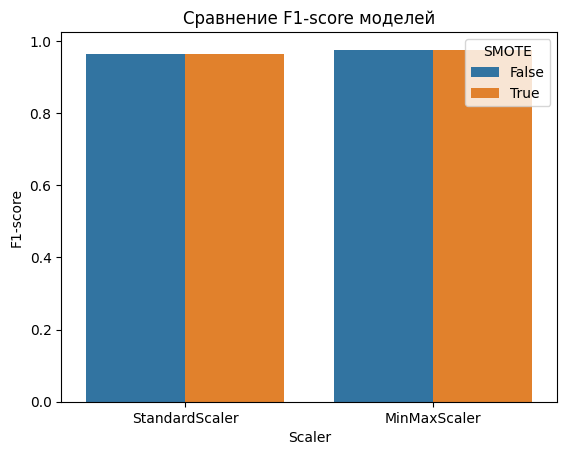

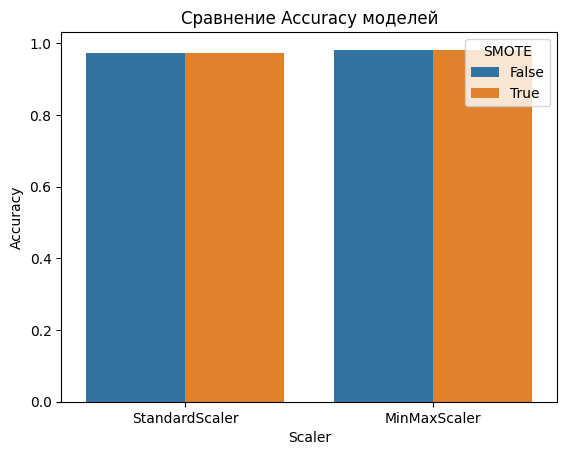

In [14]:
results_df = pd.DataFrame(results)
print(results_df)

# Визуализация
sns.barplot(data=results_df, x='Scaler', y='F1-score', hue='SMOTE')
plt.title('Сравнение F1-score моделей')
plt.show()

sns.barplot(data=results_df, x='Scaler', y='Accuracy', hue='SMOTE')
plt.title('Сравнение Accuracy моделей')
plt.show()
